# Skin lesion

## 前準備
### 主要パッケージを読み込む
loggerの設定も行う

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/skin_lesion')
CLASS_LABELS = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')
IMAGE_EXT = '.jpg'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
import tut_utils
df_dataset = tut_utils.create_dataset_df(DATA_ROOT, CLASS_LABELS, IMAGE_EXT)
assert set(CLASS_LABELS) == set(df_dataset['class_label'].unique(
)), 'Discrepancy between CLASS_LABELS and df_dataset'
display(df_dataset)

,filepath,class_label,class
0,Data\Images\skin_lesion\akiec\ISIC_0024329.jpg,akiec,0
1,Data\Images\skin_lesion\akiec\ISIC_0024450.jpg,akiec,0
2,Data\Images\skin_lesion\akiec\ISIC_0024511.jpg,akiec,0
3,Data\Images\skin_lesion\akiec\ISIC_0024522.jpg,akiec,0
4,Data\Images\skin_lesion\akiec\ISIC_0024913.jpg,akiec,0
...,...,...,...
247,Data\Images\skin_lesion\vasc\ISIC_0032076.jpg,vasc,6
248,Data\Images\skin_lesion\vasc\ISIC_0032745.jpg,vasc,6
249,Data\Images\skin_lesion\vasc\ISIC_0032839.jpg,vasc,6
250,Data\Images\skin_lesion\vasc\ISIC_0033135.jpg,vasc,6


### クラスごとの画像数を確認する

In [4]:
df_dataset['class_label'].value_counts()

bkl      36
nv       36
vasc     36
akiec    36
mel      36
bcc      36
df       36
Name: class_label, dtype: int64

### 各クラスの画像を表示してみる

akiec


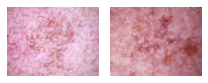

bcc


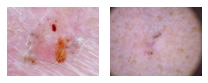

bkl


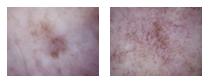

df


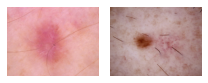

mel


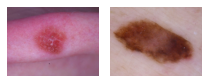

nv


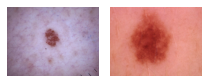

vasc


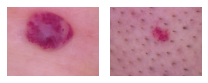

In [5]:
tut_utils.show_images_each_class(df_dataset,
                                 n_rows=1,
                                 n_cols=2,
                                 figsize=(3, 2))

### 画像読み込み用の関数を作成

In [6]:
IMG_SHAPE = (3, 224, 224)
from PIL import Image
import torch


def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize(IMG_SHAPE[1:])
    return np.atleast_3d(img)

## Data augmentation

### 試しに適用
いくつかの画像に対して実際にaugmentationを適用し表示する

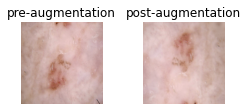

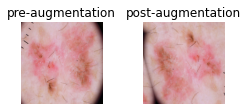

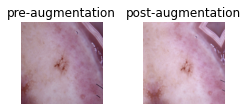

In [7]:
import albumentations as A
from tut_utils import AugmentedDataset, load_dataset

album_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=.1, contrast_limit=.1, p=.5),
    A.Flip(p=.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=.2, rotate_limit=45, p=.8)
])

N_TEST = 3


def random_transform(x, y):
    x = (x / 255).astype(np.float32)
    tfed = album_transform(image=x)
    x = tfed['image']
    x = x.transpose(2, 0, 1)  # to channels first
    return x.astype(np.float32), y


def base_transform(x, y):
    x = (x / 255).astype(np.float32)
    x = x.transpose(2, 0, 1)  # to channels first
    return x, y


def test_augmentation(df_dataset):
    df_train = df_dataset.iloc[:N_TEST]
    train_data, train_labels = load_dataset(df_train, load_img)
    dataset = AugmentedDataset(train_data, train_labels, random_transform)
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=0)
    for i, data in enumerate(loader):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(train_data[i], cmap='gray')
        plt.title('pre-augmentation')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(data[0].squeeze().numpy().transpose(1, 2, 0), cmap='gray')
        plt.title('post-augmentation')
        plt.axis('off')
        plt.show()


test_augmentation(df_dataset)

## モデル作成
[ImageNet](http://www.image-net.org/)で事前学習されたMobileNetV2を基にモデルを作成する。
[参考](https://www.tensorflow.org/tutorials/images/transfer_learning)
<div class="alert alert-block alert-warning">
<b>注意:</b> BatchNormalizationレイヤーのmomentumは手動で再設定する</div>

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models.utils import load_state_dict_from_url


class MobileNetFeatures(models.MobileNetV2):
    def __init__(
        self,
        pretrained=True,
        **kwargs,
    ):
        super().__init__(**kwargs)
        if pretrained:
            state_dict = load_state_dict_from_url(
                models.mobilenet.model_urls['mobilenet_v2'])
            self.load_state_dict(state_dict)

    def forward(self, x):
        return self.features(x)


class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = MobileNetFeatures()
        self.conv = nn.Sequential(nn.Conv2d(1280, 128, kernel_size=3),
                                  nn.BatchNorm2d(128), nn.ReLU(inplace=True),
                                  nn.Conv2d(128, 32, kernel_size=3),
                                  nn.BatchNorm2d(32), nn.ReLU(inplace=True))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(288, len(CLASS_LABELS)))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.conv(x)
        x = self.classifier(x)
        return x


from torchsummary import summary
summary(MobileNet(), IMG_SHAPE, verbose=0, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─MobileNetFeatures: 1-1                 [-1, 1280, 7, 7]          --
|    └─Sequential: 2-1                   [-1, 1280, 7, 7]          --
|    |    └─ConvBNReLU: 3-1              [-1, 32, 112, 112]        928
|    |    └─InvertedResidual: 3-2        [-1, 16, 112, 112]        896
|    |    └─InvertedResidual: 3-3        [-1, 24, 56, 56]          5,136
|    |    └─InvertedResidual: 3-4        [-1, 24, 56, 56]          8,832
|    |    └─InvertedResidual: 3-5        [-1, 32, 28, 28]          10,000
|    |    └─InvertedResidual: 3-6        [-1, 32, 28, 28]          14,848
|    |    └─InvertedResidual: 3-7        [-1, 32, 28, 28]          14,848
|    |    └─InvertedResidual: 3-8        [-1, 64, 14, 14]          21,056
|    |    └─InvertedResidual: 3-9        [-1, 64, 14, 14]          54,272
|    |    └─InvertedResidual: 3-10       [-1, 64, 14, 14]          54,272
|    |    └─InvertedResidual: 3-11       [-1, 64, 14,

## pytorch-lightning
[pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning)を用いて学習を行う。
pytorch-lightningを用いることでtrain等の定型的な関数を自作する必要がなくなる。

In [9]:
import torch.optim as optim
import pytorch_lightning as pl


class LitNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MobileNet()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

## K-Fold 交差検証
`loss`の値を早期終了の基準として使用する。
<div class="alert alert-block alert-warning">
<b>注意:</b> 今回、trainingデータを用いて学習を終了させていますが、本来はvalidationデータ(trainingでもtestでもないデータ)を用います。
</div>

2021-03-31 14:23:30,345 INFO :1th iteration of 3-fold CV
GPU available: True, used: True
2021-03-31 14:23:30,974 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:23:30,975 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:23:30,977 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MobileNet        | 5.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
2021-03-31 14:23:32,130 INFO :
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MobileNet        | 5.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     

Training: 0it [00:00, ?it/s]

2021-03-31 14:23:51,784 INFO :Finish training


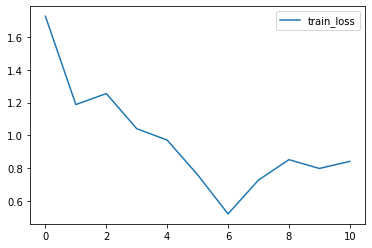

2021-03-31 14:23:55,399 INFO :2th iteration of 3-fold CV
GPU available: True, used: True
2021-03-31 14:23:56,058 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:23:56,060 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:23:56,061 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MobileNet        | 5.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
2021-03-31 14:23:56,098 INFO :
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MobileNet        | 5.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     

Training: 0it [00:00, ?it/s]

2021-03-31 14:24:25,711 INFO :Finish training


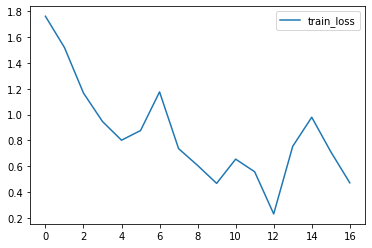

2021-03-31 14:24:29,519 INFO :3th iteration of 3-fold CV
GPU available: True, used: True
2021-03-31 14:24:30,179 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:24:30,180 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:24:30,182 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MobileNet        | 5.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
2021-03-31 14:24:30,212 INFO :
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | MobileNet        | 5.0 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     

Training: 0it [00:00, ?it/s]

2021-03-31 14:25:06,050 INFO :Finish training


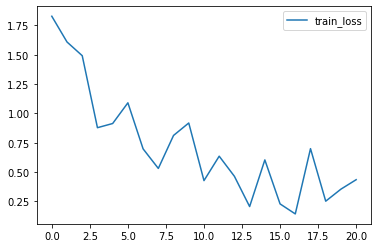

In [10]:
import os
from sklearn.model_selection import StratifiedKFold
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

K_FOLD = 3
kfold = StratifiedKFold(n_splits=K_FOLD, shuffle=True)

DEBUG = False
BATCH_SIZE = 8
NUM_WORKERS = 0 if os.name == 'nt' else 2
EPOCHS = 2 if DEBUG else 64
PATIENCE = 4


def predict_multiclass(model, loader, index):
    model.freeze()
    model.eval()

    ys = []
    with torch.no_grad():
        for batch in loader:
            x, _ = batch
            logits = model(x)
            ys.append(logits)
    logits = torch.cat(ys, axis=0)
    preds = F.softmax(logits, dim=1)
    preds = preds.cpu().numpy()
    df_result = pd.DataFrame({
        'pred_logits': list(logits.cpu().numpy()),
        'pred_proba': list(preds),
        'pred_class': np.argmax(preds, axis=1)
    })
    df_result.index = index
    return df_result


results = []
for i_iter, (train_index, test_index) in enumerate(
        kfold.split(df_dataset['filepath'], df_dataset['class'])):
    logger.info('{i}th iteration of {k}-fold CV'.format(i=i_iter + 1,
                                                        k=K_FOLD))
    df_train = df_dataset.iloc[train_index]
    df_test = df_dataset.iloc[test_index]
    train_data, train_labels = load_dataset(df_train, load_img)
    test_data, test_labels = load_dataset(df_test, load_img)
    model = LitNet()
    dataset = AugmentedDataset(train_data, train_labels, random_transform)
    trainloader = torch.utils.data.DataLoader(dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
    early_stop_callback = EarlyStopping(monitor='train_loss',
                                        patience=PATIENCE,
                                        verbose=True,
                                        mode='min')
    csv_logger = CSVLogger('train_logs', name='skin_lesion')
    trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else 0,
                         max_epochs=EPOCHS,
                         logger=csv_logger,
                         log_every_n_steps=len(trainloader),
                         callbacks=[early_stop_callback])
    trainer.fit(model, trainloader)
    logger.info('Finish training')
    df_logs = pd.read_csv(csv_logger.experiment.metrics_file_path)
    df_logs.plot(y='train_loss')
    plt.show()
    dataset = AugmentedDataset(test_data, test_labels, base_transform)
    testloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=NUM_WORKERS)

    df_result = predict_multiclass(model, testloader, test_index)
    results.append(df_result)
#     break

### テスト結果

In [11]:
df_result = pd.concat(results, axis=0)
df_result = df_dataset.join(df_result)
display(df_result)

,filepath,class_label,class,pred_logits,pred_proba,pred_class
0,Data\Images\skin_lesion\akiec\ISIC_0024329.jpg,akiec,0,"[1.2920845, 1.0699552, -0.38711792, -0.4194856...","[0.42640528, 0.34147042, 0.07953427, 0.0770011...",0
1,Data\Images\skin_lesion\akiec\ISIC_0024450.jpg,akiec,0,"[0.86791, 0.94399536, -0.7762477, -0.9198698, ...","[0.2666558, 0.28773618, 0.05151129, 0.04461985...",1
2,Data\Images\skin_lesion\akiec\ISIC_0024511.jpg,akiec,0,"[-0.110471725, 1.1809632, 0.36672527, -0.81503...","[0.1108296, 0.4031984, 0.17860754, 0.054785874...",1
3,Data\Images\skin_lesion\akiec\ISIC_0024522.jpg,akiec,0,"[0.6859671, 0.8106479, -0.5748179, -0.6341585,...","[0.30121776, 0.34121552, 0.08537459, 0.0804558...",1
4,Data\Images\skin_lesion\akiec\ISIC_0024913.jpg,akiec,0,"[1.2573531, 0.84850186, -0.46625516, 0.4986542...","[0.40585604, 0.26965606, 0.072413325, 0.190052...",0
...,...,...,...,...,...,...
247,Data\Images\skin_lesion\vasc\ISIC_0032076.jpg,vasc,6,"[-1.2608061, 0.016392156, -1.5140952, -0.33886...","[0.005866567, 0.021040894, 0.0045538833, 0.014...",6
248,Data\Images\skin_lesion\vasc\ISIC_0032745.jpg,vasc,6,"[-1.3792217, -1.6069567, 0.02683713, -1.082055...","[0.0119450595, 0.009512272, 0.048733983, 0.016...",6
249,Data\Images\skin_lesion\vasc\ISIC_0032839.jpg,vasc,6,"[-0.2955462, -0.93621266, -0.596717, -0.814055...","[0.029373279, 0.015477988, 0.021734798, 0.0174...",6
250,Data\Images\skin_lesion\vasc\ISIC_0033135.jpg,vasc,6,"[-1.2412767, -0.83044076, -0.97186804, -0.9979...","[0.017388152, 0.026222691, 0.022764398, 0.0221...",6


## 評価
### 混同行列

In [12]:
df_cm = tut_utils.confusion_matrix(df_result)
print('Accuracy = {n} / {d} = {a:.03g}%'.format(n=df_cm.values.trace(),
                                                d=df_cm.values.sum(),
                                                a=100 * df_cm.values.trace() /
                                                df_cm.values.sum()))

display(df_cm)

Accuracy = 144 / 252 = 57.1%


Prediction,akiec,bcc,bkl,df,mel,nv,vasc
Truth,,,,,,,
akiec,17,5,6,4,4,0,0
bcc,8,14,2,4,2,2,4
bkl,0,1,23,3,6,2,1
df,1,1,2,23,2,7,0
mel,1,1,5,2,11,15,1
nv,1,0,1,5,5,24,0
vasc,0,1,0,1,0,2,32


### ROCカーブ

(7, 252)


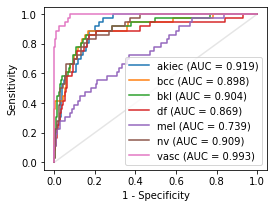

In [13]:
tut_utils.plot_roc_curves(df_result, figsize=(4, 3))
plt.show()